# Augmenting STS Dataset with SBERT

## Requirements

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from pathlib import Path
import scipy.special as special
import csv
import numpy as np
from sentence_transformers import SentenceTransformer, util
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

data_dir = Path('data')
assert data_dir.exists()
output_dir = Path('data')
output_dir.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

## Load STS Benchmark Dataset

In [2]:
%%capture
df_sts = pd.read_csv(data_dir / "stsbenchmark" / 'sts-train.csv', error_bad_lines=False, header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
df_sts = df_sts.rename(columns={0: "genre", 1: "filename", 2: "year", 3: "trash", 4: "score", 5: "s1", 6: "s2"})

In [3]:
df_sts.genre = df_sts.genre.astype("category")
df_sts.filename = df_sts.filename.astype("category")
df_sts.year = df_sts.year.astype("category")
df_sts.genre = df_sts.genre.astype("category")

In [4]:
df_sts

,genre,filename,year,trash,score,s1,s2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...,...,...,...,...
5547,main-news,headlines,2015,1489,1.20,"Palestinian hunger striker, Israel reach deal",Palestinian activist detained in Israeli raid
5548,main-news,headlines,2015,1493,4.80,Assad says Syria will comply with UN arms reso...,Syria's Assad vows to comply with U.N. resolution
5549,main-news,headlines,2015,1496,4.60,South Korean President Sorry For Ferry Response,S. Korean president 'sorry' for ferry disaster
5550,main-news,headlines,2015,1498,0.00,Food price hikes raise concerns in Iran,American Chris Horner wins Tour of Spain


## Compute Embeddings

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
s1_embeds = model.encode(df_sts.s1, convert_to_tensor=True, device=device)
s2_embeds = model.encode(df_sts.s2, convert_to_tensor=True, device=device)
# normalize embeddings, reshape for later cosine similarity
s1_embeds = F.normalize(s1_embeds).unsqueeze(1)
s2_embeds = F.normalize(s2_embeds).unsqueeze(2)
# print shapes
print(s1_embeds.shape, s2_embeds.shape)

torch.Size([5552, 1, 384]) torch.Size([5552, 384, 1])


## Create new sentence pairs and score them via cosine similarity

In [7]:
# get the index of the unique sentences
s1_unique_idxs = df_sts.s1.drop_duplicates().index.values
s2_unique_idxs = df_sts.s2.drop_duplicates().index.values
# create array that holds all possible index combinations
index_pairs = np.stack(np.meshgrid(s1_unique_idxs, s2_unique_idxs), axis=-1).reshape(-1, 2)
index_pairs.shape

(27441810, 2)

In [8]:
dataloader = torch.utils.data.DataLoader(index_pairs, batch_size=8192)
scores = torch.cat([
    s1_embeds[idxs[:, 0]] @ s2_embeds[idxs[:, 1]]
    for idxs in tqdm(dataloader)
]).squeeze().cpu()

  0%|          | 0/3350 [00:00<?, ?it/s]

In [9]:
df_augment = pd.DataFrame({
    "idx1": index_pairs[..., 0],
    "idx2": index_pairs[..., 1],
    "score": scores.numpy()
})
df_augment

,idx1,idx2,score
0,0,0,0.939303
1,1,0,0.067502
2,2,0,0.063003
3,3,0,-0.007448
4,4,0,0.039570
...,...,...,...
27441805,5547,5551,0.220151
27441806,5548,5551,0.609874
27441807,5549,5551,0.157189
27441808,5550,5551,0.143906


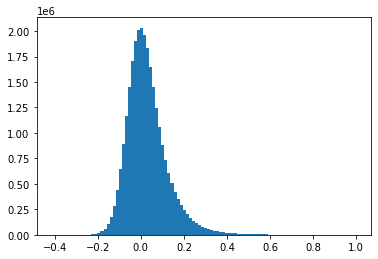

In [10]:
plt.hist(df_augment.score, bins=100)
plt.show()

In [11]:
# select evenly distributed
bins = np.histogram_bin_edges(df_augment.score, bins=1000)
indices = np.digitize(df_augment.score, bins)
indices.shape

(27441810,)

In [12]:
N_SAMPLE = 1_000
sample_idxs = []

for i in tqdm(range(1000)):
    bin_indices = np.where(indices == i)[0]
    if len(bin_indices) > 1:
        sample_idxs.append(np.random.choice(bin_indices, size=N_SAMPLE))

sample_idxs = np.concatenate(sample_idxs)

  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
df_augment = df_augment.iloc[sample_idxs].reset_index()
df_augment

In [ ]:
plt.hist(df_augment.score, bins=100)
plt.show()

In [ ]:
df_augment.to_feather(output_dir / "df_augment.feather")